In [45]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [46]:
#define common variables
channels = 3 #RGB
img_w = 64
img_h = 64
input_shape = (img_h, img_w, channels)
path = "../satellite_images/images"

In [47]:
#create tf datasets from the images: tf.Data.dataset
# labels NoTrees = 0, Trees = 1

training = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='training')

validation = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='validation')

Found 10332 files belonging to 2 classes.
Using 8266 files for training.
Found 10332 files belonging to 2 classes.
Using 2066 files for validation.


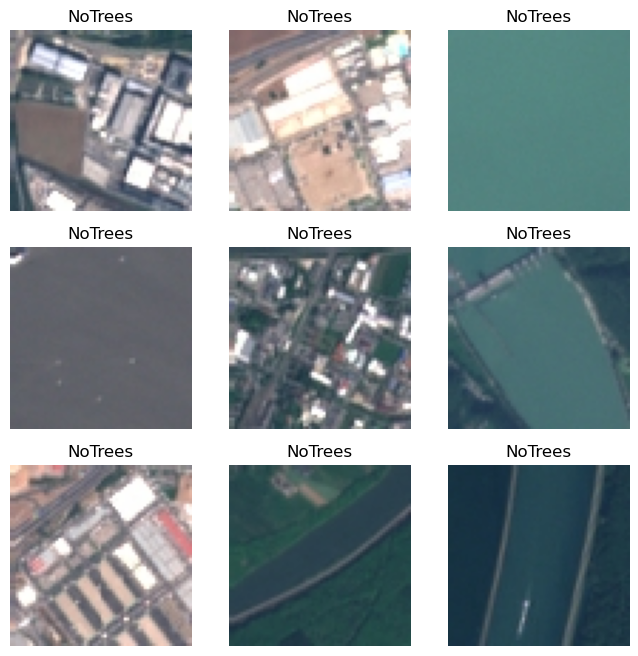

In [48]:
#show first 9 images and labels from the training set:
class_names = training.class_names

plt.figure(figsize=(8, 8))
for images, labels in training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
        plt.axis("off")

In [49]:
#split the validation dataset into validation and test datasets
val_batches = tf.data.experimental.cardinality(validation)
test_dataset = validation.take(val_batches // 5)
validation = validation.skip(val_batches // 5)

In [50]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 104
Number of test batches: 26


In [51]:
# performance configuration: Use buffered prefetching to load images from disk
AUTOTUNE = tf.data.AUTOTUNE

training = training.prefetch(buffer_size=AUTOTUNE)
validation = validation.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

I will use transfer learning with a pre-trained network as a starting point for this classification task, and compare to the from-scratch networks that I built. The idea behind transfer learning for image classification is that if a model is trained on a large, general dataset, it will effectively serve as a generic model that can then be applied to other datasets by allowing you to take advantage of these learned feature maps. I will first try using the MobileNet V2 model developed by Google, which is pre-trained on the ImageNet dataset (1.4M images, 1000 classes).

The MobileNetV2 model expects pixel values from [-1,1] instead of the [0,255] that the images are in currently. So I will first need to rescale them:

In [52]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [53]:
# Create the base model from the pre-trained model MobileNet V2
img_size = (64,64)
img_shape = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

In [54]:
# convert each image into a bblock of features
image_batch, label_batch = next(iter(training))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 2, 2, 1280)


In [55]:
# Freeze the convolutional base before compiling and training the model. This prevents the weights
# in a given layer from being updated before training. 
base_model.trainable = False

In [56]:
# Let's see the base model's summary
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 8, 8, 144)   576         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 8, 8, 144)    0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 8, 8, 32)     4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 8, 8, 32)    128         ['block_3_project[0][0]']        
 lization)                                                                                        
          

                                                                                                  
 block_7_expand_relu (ReLU)     (None, 4, 4, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 4, 4, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 4, 4, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_depthwise_relu (ReLU)  (None, 4, 4, 384)    0           ['block_7_depthwise_BN[0][0]']   
          

 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 4, 4, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 4, 4, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 4, 4, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_depthwise (DepthwiseC  (None, 4, 4, 576)   5184        ['block_11_expand_relu[0][0]']   
 onv2D)   

 block_14_depthwise_relu (ReLU)  (None, 2, 2, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 2, 2, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 2, 2, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 2, 2, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_

In [57]:
# generate predictions from the block of features by averaging over the 2x2 spatial locations, 
# using a GlobalAveragePooling2D layer to convert the features to a single 
# 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [58]:
# Apply a Dense layer to convert these features into a single prediction per image. 
# no activation function here because this prediction will be treated as a logit (raw prediction value)
#Positive numbers predict class 1, negative numbers class 0.

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [59]:
#build a model with rescaling, basemodel, and feature extrator layers
inputs = tf.keras.Input(shape=(64, 64, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [60]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 64, 64, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 64, 64, 3)        0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [62]:
len(model.trainable_variables)

2

The 2.2 million MobileNet parameters are frozen but there are about 1200 trainable parameters in the Dense layer (divided between 2 tf variable objects -  weights and biases).

In [64]:
#train the model for 10 epochs
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

104/104 [==============================] - 11s 80ms/step - loss: 0.8641 - accuracy: 0.5012
initial loss: 0.86
initial accuracy: 0.50


In [66]:
history = model.fit(training,
                    epochs=initial_epochs,
                    validation_data=validation)

Epoch 1/10
517/517 [==============================] - 66s 123ms/step - loss: 0.5498 - accuracy: 0.7007 - val_loss: 0.3447 - val_accuracy: 0.8236
Epoch 2/10
517/517 [==============================] - 40s 77ms/step - loss: 0.3451 - accuracy: 0.8338 - val_loss: 0.2660 - val_accuracy: 0.8782
Epoch 3/10
517/517 [==============================] - 42s 81ms/step - loss: 0.2798 - accuracy: 0.8755 - val_loss: 0.2311 - val_accuracy: 0.8994
Epoch 4/10
517/517 [==============================] - 48s 92ms/step - loss: 0.2460 - accuracy: 0.8906 - val_loss: 0.2009 - val_accuracy: 0.9152
Epoch 5/10
517/517 [==============================] - 38s 73ms/step - loss: 0.2203 - accuracy: 0.9078 - val_loss: 0.1858 - val_accuracy: 0.9248
Epoch 6/10
517/517 [==============================] - 33s 64ms/step - loss: 0.2056 - accuracy: 0.9127 - val_loss: 0.1758 - val_accuracy: 0.9321
Epoch 7/10
517/517 [==============================] - 31s 60ms/step - loss: 0.1953 - accuracy: 0.9208 - val_loss: 0.1627 - val_accuracy

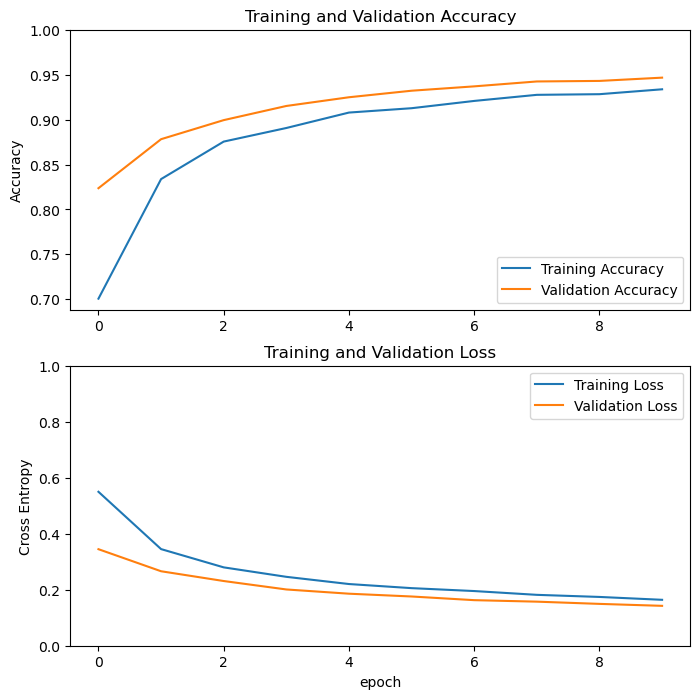

In [67]:
#plot training and validation learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In the above feature extraction model, I only trained a few new layers on top of the MobileNetV2 model, and the weights of the pre-trained model were not updated during training. Next, I will take a look at fine-tuning the weights of the top layers of the pretrained model also. This will change the weights to being tuned to generic feature maps to maps of features more specifically associated with the forest satellite image dataset.